In [3]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from torch import nn
import random

In [4]:
import sys
sys.path.append("..")
# from steganogan.decoders import DenseDecoderNLayers
from steganogan.decoders import BasicDecoder, DenseDecoder, DenseDecoderNLayers
from steganogan import SteganoGAN

In [109]:
import torch
import torchvision
from torch.optim import LBFGS
import torch.nn.functional as F

In [5]:
from tqdm import tqdm, trange

In [79]:
def shuffle_params(m):
    if type(m)==nn.Conv2d or type(m)==nn.BatchNorm2d:
        param = m.weight
        m.weight.data = nn.Parameter(torch.tensor(np.random.normal(0, 1, param.shape)).float())
        
        param = m.bias
        m.bias.data = nn.Parameter(torch.zeros(len(param.view(-1))).float().reshape(param.shape))
    if type(m)==nn.BatchNorm2d:
        m.track_running_stats=False
#         

In [81]:
class BasicDecoder(nn.Module):
    """
    The BasicDecoder module takes an steganographic image and attempts to decode
    the embedded data tensor.

    Input: (N, 3, H, W)
    Output: (N, D, H, W)
    """

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.layers = nn.Sequential(
            self._conv2d(3, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),

            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),

            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),

            self._conv2d(self.hidden_size, self.data_depth)
        )

        return [self.layers]

    def __init__(self, data_depth, hidden_size):
        super().__init__()
        self.version = '1'
        self.data_depth = data_depth
        self.hidden_size = hidden_size

        self._models = self._build_models()

    def upgrade_legacy(self):
        """Transform legacy pretrained models to make them usable with new code versions."""
        # Transform to version 1
        if not hasattr(self, 'version'):
            self._models = [self.layers]

            self.version = '1'

    def forward(self, x):
        x = self._models[0](x)

        if len(self._models) > 1:
            x_list = [x]
            for layer in self._models[1:]:
                x = layer(torch.cat(x_list, dim=1))
                x_list.append(x)

        return x

In [71]:
#yan
class BasicDecoder(nn.Module):
    """
    The BasicDecoder module takes an steganographic image and attempts to decode
    the embedded data tensor.

    Input: (N, 3, H, W)
    Output: (N, D, H, W)
    """

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.layers = nn.Sequential(
            self._conv2d(3, self.hidden_size),
            nn.LeakyReLU(inplace=True),
#             nn.BatchNorm2d(self.hidden_size),
#             nn.LayerNorm([self.hidden_size,450,612]),

            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
#             nn.BatchNorm2d(self.hidden_size),
#             nn.LayerNorm([self.hidden_size,450,612]),

            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
#             nn.BatchNorm2d(self.hidden_size),
#                         nn.LayerNorm([self.hidden_size,450,612]),


            self._conv2d(self.hidden_size, self.data_depth)
        )

        return [self.layers]

    def __init__(self, data_depth, hidden_size):
        super().__init__()
        self.version = '1'
        self.data_depth = data_depth
        self.hidden_size = hidden_size

        self._models = self._build_models()

    def upgrade_legacy(self):
        """Transform legacy pretrained models to make them usable with new code versions."""
        # Transform to version 1
        if not hasattr(self, 'version'):
            self._models = [self.layers]

            self.version = '1'

    def forward(self, x):
        x = self._models[0](x)

        if len(self._models) > 1:
            x_list = [x]
            for layer in self._models[1:]:
                x = layer(torch.cat(x_list, dim=1))
                x_list.append(x)

        return x

In [87]:
# models
model_name = "steg_decode_new"
if model_name == "steg_decode":
#     steganogan = SteganoGAN.load(architecture='dense', path=None, cuda=True, verbose=True)
    steganogan = SteganoGAN.load(path="demo_1.1.steg", cuda=True, verbose=True)
    model = steganogan.decoder
    model.apply(shuffle_params)
elif model_name == "steg_decode_new":
    model = BasicDecoder(1, hidden_size=32)
    model.apply(shuffle_params)
    model.to('cuda')
else:
    print("unknown model")

model.to('cuda')
print(model.layers[2].track_running_stats)
old_dict = model.state_dict()

False


In [16]:
print(model.layers[2])
print(model.layers[2].weight)
print(model.layers[2].bias)

BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Parameter containing:
tensor([-1.1785, -1.3337,  0.4845, -0.4525, -0.6166, -0.6717,  0.7047, -0.0674,
         0.8078, -0.1451,  0.0772,  0.1692, -0.8882, -0.2358,  1.7108,  0.2523,
         0.3208,  0.7993,  0.2816,  1.9776, -0.8120,  0.6730, -1.1153, -0.1584,
        -0.7668, -1.7591,  0.2537,  1.9615,  1.2573,  2.4311,  1.6465, -1.1338],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True)


In [17]:
model.layers[2].weight.requires_grad

True

In [18]:
# load image
image = "/home/vk352/FaceDetection/datasets/sample/obama2.jpg"
image = imread(image, pilmode='RGB') 
image.shape

(612, 450, 3)

In [84]:
# extract a bit vector
# image = "/home/vk352/FaceDetection/datasets/sample/obama2.jpg"
image = "/home/vk352/FaceDetection/datasets/data512x512/00001.jpg"
image = imread(image, pilmode='RGB') / 255.0
image = torch.FloatTensor(image).permute(2, 1, 0).unsqueeze(0)
image = image.to('cuda')
out = model(image)
# image = self.decoder(image).view(-1) > 0

In [53]:
target = torch.bernoulli(torch.empty(out.shape).uniform_(0, 1)).to(out.device)
target.shape

torch.Size([1, 1, 512, 512])

In [115]:
loss_mode = "log"
hinge = 0.3

In [ ]:
# lbfgs

lbfgsacc = {}
lbfgsimg = {}

steps = 2000
eps = 0.2
adv_image = image.clone().detach()
max_iter = 20

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
criterion2 = torch.nn.MSELoss(reduction='sum')
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5]:
    print("alpha:", alpha)
    accuracy = []

    for i in trange(steps // max_iter):
        adv_image.requires_grad = True
        optimizer = LBFGS([adv_image], lr=alpha, max_iter=max_iter)

        def closure():
            outputs = model(adv_image)

            if loss_mode == "BCE":
                loss = criterion(outputs, target)
            elif loss_mode == "log":
                loss = -(target * 2 - 1) * outputs
                loss = torch.nn.functional.softplus(loss)  # log(1+exp(x))
                loss = torch.sum(loss)
            elif loss_mode == "hingelog":
                loss = -(target * 2 - 1) * outputs
                loss = torch.nn.functional.softplus(loss)  # log(1+exp(x))
                loss = torch.max(loss-hinge, torch.zeros(target.shape).to(target.device))
                loss = torch.sum(loss)
            elif loss_mode == "L2":
                outputs = F.sigmoid(outputs)
                loss = criterion2(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        delta = torch.clamp(adv_image - image, min=-eps, max=eps)
        adv_image = torch.clamp(image + delta, min=0, max=1).detach()

        acc = len(torch.nonzero((model(adv_image)>0).float().view(-1) != target.view(-1))) / target.numel()
        print(acc)
        accuracy.append(acc)

    lbfgsacc[alpha] = accuracy
    lbfgsimg[alpha] = adv_image.cpu().squeeze().permute(2,1,0)


  0%|          | 0/100 [00:00<?, ?it/s]

alpha: 0.1



  1%|          | 1/100 [00:00<00:49,  2.02it/s]

0.35083770751953125



  2%|▏         | 2/100 [00:00<00:47,  2.05it/s]

0.13568878173828125



  3%|▎         | 3/100 [00:01<00:46,  2.06it/s]

0.054180145263671875



  4%|▍         | 4/100 [00:01<00:46,  2.07it/s]

0.0256805419921875



  5%|▌         | 5/100 [00:02<00:45,  2.08it/s]

0.37322998046875



  6%|▌         | 6/100 [00:02<00:44,  2.09it/s]

0.23281097412109375



  7%|▋         | 7/100 [00:03<00:44,  2.10it/s]

0.35976409912109375



  8%|▊         | 8/100 [00:03<00:43,  2.10it/s]

0.19222259521484375



  9%|▉         | 9/100 [00:04<00:43,  2.10it/s]

0.08928680419921875



 10%|█         | 10/100 [00:04<00:42,  2.10it/s]

0.033580780029296875



 11%|█         | 11/100 [00:05<00:42,  2.11it/s]

0.01239013671875



 12%|█▏        | 12/100 [00:05<00:41,  2.11it/s]

0.0048370361328125



 13%|█▎        | 13/100 [00:06<00:41,  2.12it/s]

0.00211334228515625



 14%|█▍        | 14/100 [00:06<00:40,  2.11it/s]

0.001018524169921875



 15%|█▌        | 15/100 [00:07<00:40,  2.11it/s]

0.000431060791015625



 16%|█▌        | 16/100 [00:07<00:39,  2.12it/s]

0.0001983642578125



 17%|█▋        | 17/100 [00:08<00:39,  2.11it/s]

9.5367431640625e-05



 18%|█▊        | 18/100 [00:08<00:38,  2.10it/s]

5.7220458984375e-05



 19%|█▉        | 19/100 [00:09<00:38,  2.11it/s]

4.9591064453125e-05



 20%|██        | 20/100 [00:09<00:37,  2.11it/s]

4.9591064453125e-05



 21%|██        | 21/100 [00:09<00:37,  2.11it/s]

3.814697265625e-05



 22%|██▏       | 22/100 [00:10<00:37,  2.10it/s]

3.0517578125e-05



 23%|██▎       | 23/100 [00:10<00:36,  2.10it/s]

2.288818359375e-05



 24%|██▍       | 24/100 [00:11<00:36,  2.09it/s]

1.52587890625e-05



 25%|██▌       | 25/100 [00:11<00:36,  2.08it/s]

1.9073486328125e-05



 26%|██▌       | 26/100 [00:12<00:35,  2.08it/s]

3.814697265625e-06


# max_iter = 20

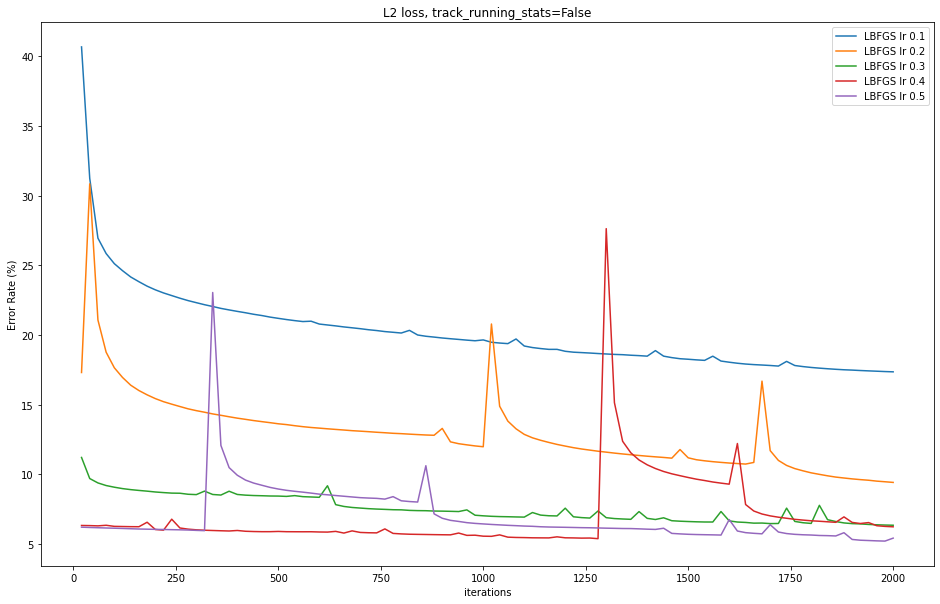

In [112]:
plt.figure(figsize=(16, 10))
# plt.plot(range(1000), np.array(bceacc) * 100, label="SGD")
for lr, acc in lbfgsacc.items():
    plt.plot(np.arange(1, steps // max_iter + 1) * max_iter, np.array(acc[:steps // max_iter]) * 100, label=f"LBFGS lr {lr}")
plt.legend()
plt.ylabel("Error Rate (%)")
plt.xlabel("iterations")
plt.title(f"{loss_mode} loss, track_running_stats=False")
# plt.ylim(0, 0.2)
plt.show()

In [92]:
new_weights = model.state_dict()

In [96]:
for k in new_weights.keys():
    print(k, torch.norm(old_dict[k].float() - new_weights[k].float()))

layers.0.weight tensor(0., device='cuda:0')
layers.0.bias tensor(0., device='cuda:0')
layers.2.weight tensor(0., device='cuda:0')
layers.2.bias tensor(0., device='cuda:0')
layers.2.running_mean tensor(0., device='cuda:0')
layers.2.running_var tensor(0., device='cuda:0')
layers.2.num_batches_tracked tensor(0., device='cuda:0')
layers.3.weight tensor(0., device='cuda:0')
layers.3.bias tensor(0., device='cuda:0')
layers.5.weight tensor(0., device='cuda:0')
layers.5.bias tensor(0., device='cuda:0')
layers.5.running_mean tensor(0., device='cuda:0')
layers.5.running_var tensor(0., device='cuda:0')
layers.5.num_batches_tracked tensor(0., device='cuda:0')
layers.6.weight tensor(0., device='cuda:0')
layers.6.bias tensor(0., device='cuda:0')
layers.8.weight tensor(0., device='cuda:0')
layers.8.bias tensor(0., device='cuda:0')
layers.8.running_mean tensor(0., device='cuda:0')
layers.8.running_var tensor(0., device='cuda:0')
layers.8.num_batches_tracked tensor(0., device='cuda:0')
layers.9.weight 

In [32]:
accs.keys()

dict_keys(['hingelogacc', 'bceacc', 'hingeacc', 'logacc'])

In [31]:
import pickle
with open("accs.pkl", "rb") as f:
    accs = pickle.load(f)

In [245]:
image.shape

torch.Size([1, 3, 450, 612])

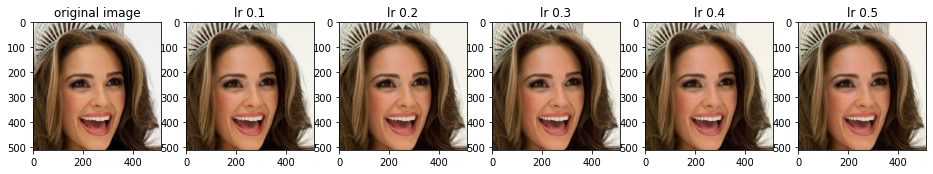

In [104]:
fig, axs = plt.subplots(1, len(lbfgsimg)+1, figsize=(16, 6))

axs[0].imshow(image.cpu().squeeze().permute(2,1,0))
axs[0].set_title("original image")
for i, alpha in enumerate([0.1, 0.2, 0.3, 0.4, 0.5]):
    axs[i+1].imshow(lbfgsimg[alpha])
    axs[i+1].set_title(f"lr {alpha}")

In [170]:
print("Number of Incorrect bits:")
print(len(torch.nonzero(output.float().view(-1) != target.view(-1))))
print("Total bits:")
print(target.numel())
print("Error rate:")
print(len(torch.nonzero(output.float().view(-1) != target.view(-1))) / target.numel())

Number of Incorrect bits:
44
Total bits:
275400
Error rate:
0.0001597676107480029


In [105]:
len(lbfgsacc[0.5])

100